# ADSP Final Project Stock Price Prediction 

In [15]:
import pandas as pd
import numpy as np
import scipy as sp
from Data import * 
from Model import * 
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from prophet.diagnostics import cross_validation
from prophet import Prophet
from arch import arch_model
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats import BATS
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_scaled_error

## 0. Data Fetching 

In [16]:
DAL = get_ETF_data('DAL', '2000-01-01', '2024-01-01')
#MSFT.to_csv('msft.csv', index=True)

In [17]:
temp_DAL = DAL.resample('M').mean() 

In [18]:
train_dal, val_dal, test_dal = split_time_series(DAL, 0.6,0.2)
#train_msft.to_csv('train_msft.csv', index=True)
#val_msft.to_csv('val_msft.csv', index=True)
#test_msft.to_csv('test_msft.csv', index=True)

In [19]:
display(DAL.head(5))

,adj_close
date,
2007-05-03,18.240466
2007-05-04,18.469352
2007-05-07,17.923546
2007-05-08,17.280905
2007-05-09,17.421758


## 1. EDA 

In [20]:
check_data_summary(DAL)

Number of rows: 4195
Number of columns: 1
Column names:
Index(['adj_close'], dtype='object')
Data types:
adj_close    float64
dtype: object
Summary statistics:
         adj_close
count  4195.000000
mean     29.232412
std      16.676037
min       3.459702
25%      10.806067
50%      33.101171
75%      42.996531
max      61.692342
Missing values:
adj_close    0
dtype: int64
No duplicated index values.


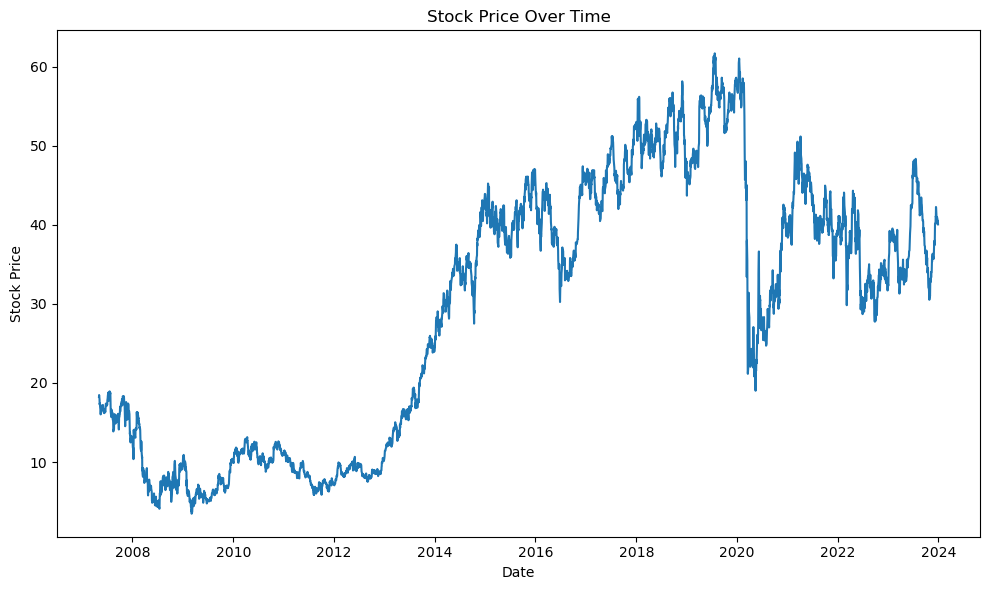

In [21]:
plot_stock_price(DAL)

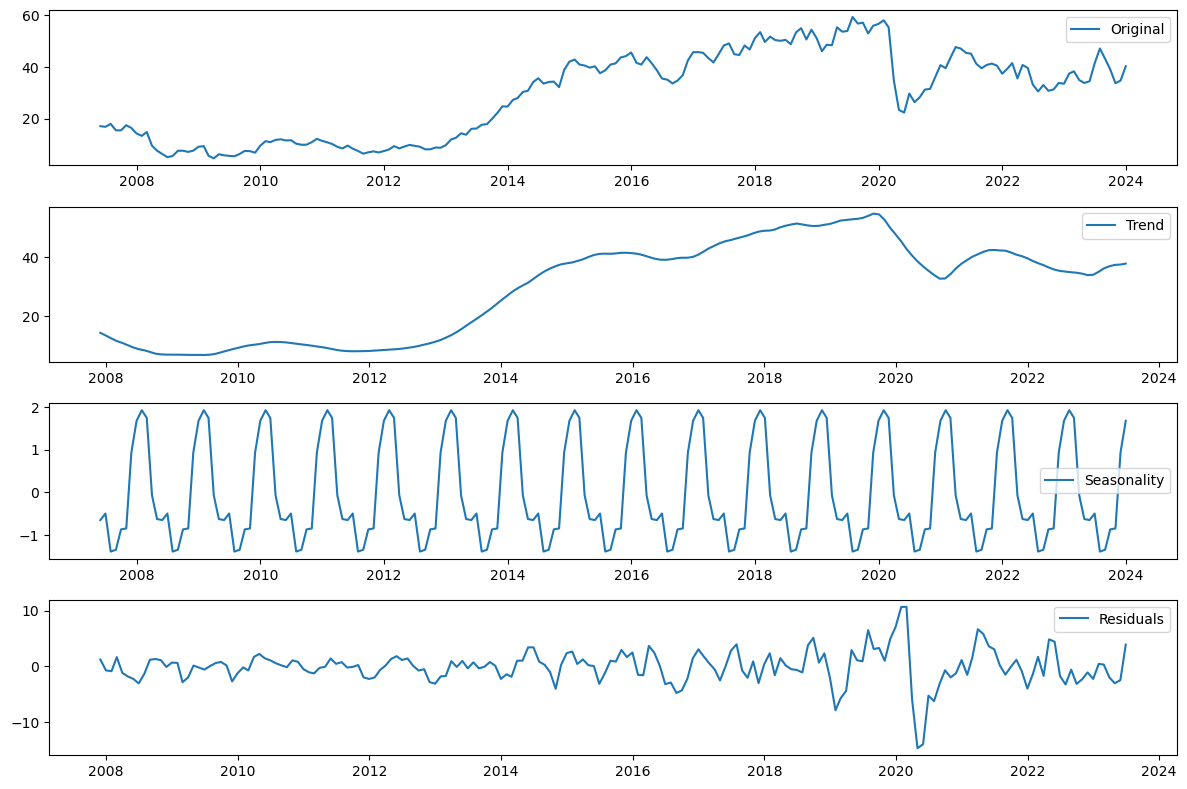

In [22]:
decompose_and_plot(temp_DAL,12)

In [23]:
check_stationarity(train_dal)

Results of Dickey-Fuller Test for adj_close:
Test Statistic                   -0.324948
p-value                           0.921896
#Lags Used                        0.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64
Results of KPSS Test for adj_close:
Test Statistic            6.366764
p-value                   0.010000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
adj_close time series data is not stationary


<Figure size 600x300 with 0 Axes>

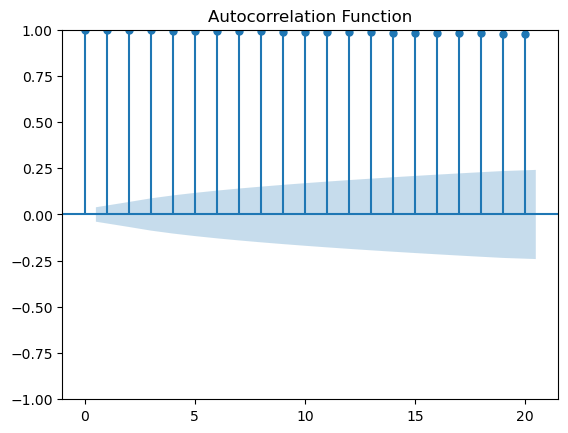

<Figure size 600x300 with 0 Axes>

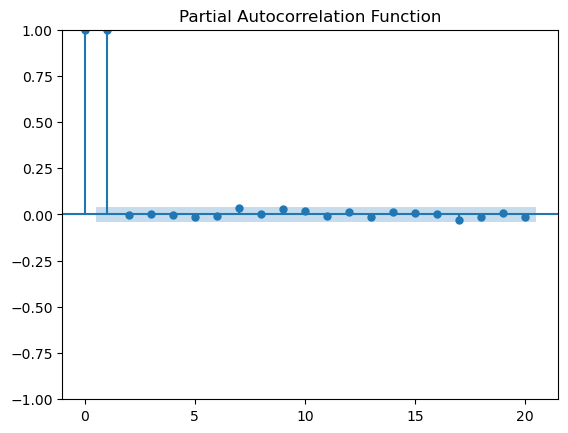

In [24]:
plot_time_series_analysis(train_dal,'adj_close')

## 2.Smoothing

In [25]:
model = fit_smoothing(train_dal)
y_test = val_dal 
y_pred = model.forecast(len(y_test))
y_pred.index = y_test.index

In [26]:
result = tune_param(train_dal,val_dal['adj_close'],methods=['add','mul'],periods=[20,64,128,252])
result

,methods,periods,mae,mse,mape,smape
0,add,20,8.819206,119.749393,0.232921,0.200088
1,add,64,8.720698,119.375062,0.231598,0.197823
2,add,128,8.316058,117.604619,0.225957,0.1886
3,add,252,8.42463,114.092719,0.225176,0.191703
4,mul,20,8.503009,124.562631,0.232823,0.192405
5,mul,64,7.584279,155.938841,0.23488,0.1694
6,mul,128,8.113371,217.377097,0.263349,0.172331
7,mul,252,9.558385,223.75038,0.286727,0.199246


In [27]:
best_param = result.loc[result['smape'].idxmin(), ['methods', 'periods']].tolist()
best_param 

['mul', 64]

In [28]:
smoothing_error_metrics = result.iloc[7]

In [29]:
smoothing_error_metrics = smoothing_error_metrics.to_frame().T

In [30]:
smoothing_error_metrics.drop(columns=['methods','periods'], inplace=True)
smoothing_error_metrics['methods'] = 'smoothing'
smoothing_error_metrics.set_index('methods', inplace=True)
smoothing_error_metrics.columns = ['MAE','MSE','MAPE','sMAPE']
smoothing_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
smoothing,9.558385,223.75038,0.286727,0.199246


## 3.ARIMA 

In [31]:
check_num_stationarity(train_dal['adj_close'])

The time series data is stationary.
Number of differencing needed is: 1


In [32]:
train_dal_diff = train_dal.loc[:,['adj_close']].diff().dropna()
check_stationarity(train_dal_diff)

Results of Dickey-Fuller Test for adj_close:
Test Statistic                  -49.852414
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2515.000000
Critical Value (1%)              -3.432953
Critical Value (5%)              -2.862690
Critical Value (10%)             -2.567382
dtype: float64
Results of KPSS Test for adj_close:
Test Statistic           0.2573
p-value                  0.1000
Lags Used                1.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64
adj_close time series data is stationary


<Figure size 600x300 with 0 Axes>

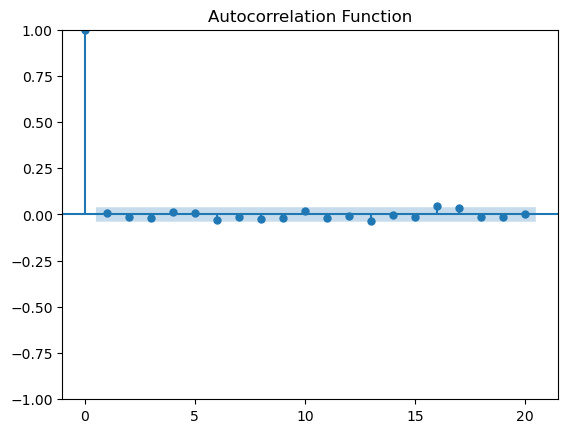

<Figure size 600x300 with 0 Axes>

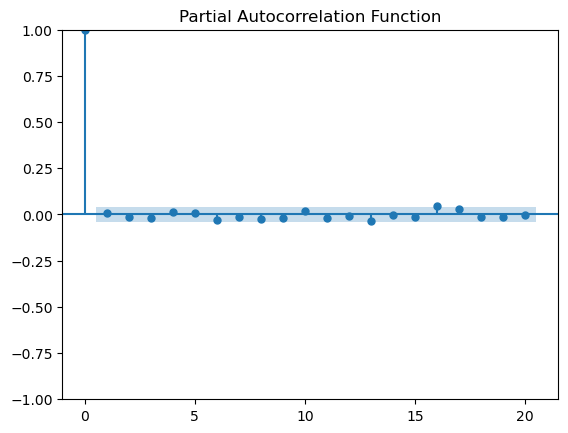

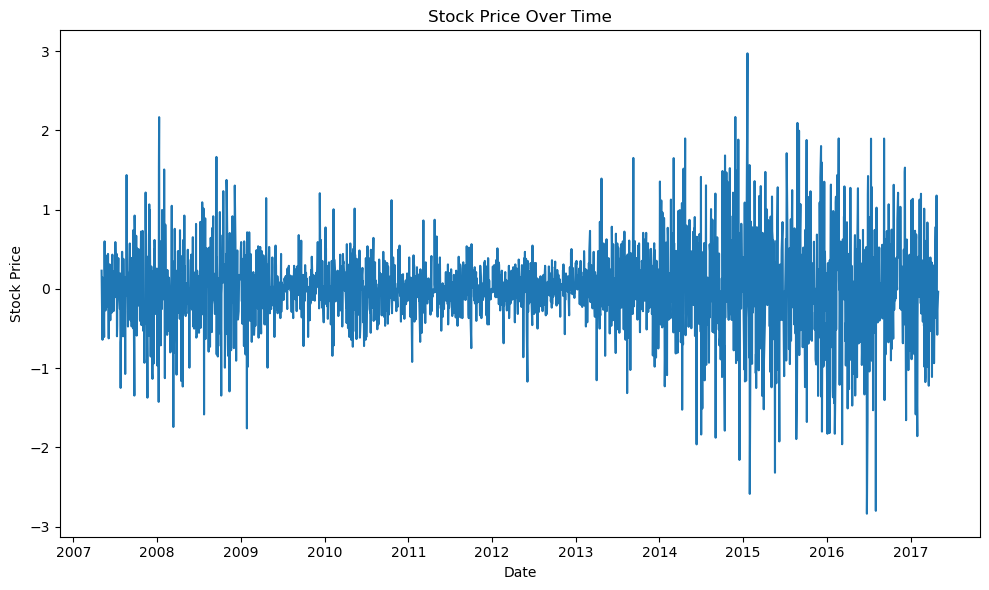

In [33]:
plot_time_series_analysis(train_dal_diff,'adj_close')
plot_stock_price(train_dal_diff)

In [34]:
arma_model = ARIMA(train_dal, order=(0,1,0))
model_fit = arma_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                 2517
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1979.499
Date:                Fri, 24 May 2024   AIC                           3960.998
Time:                        09:58:54   BIC                           3966.828
Sample:                             0   HQIC                          3963.114
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2824      0.005     56.654      0.000       0.273       0.292
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1024.72
Prob(Q):                              0.78   Pr

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.141111,0.615056,8.110402,0.618054


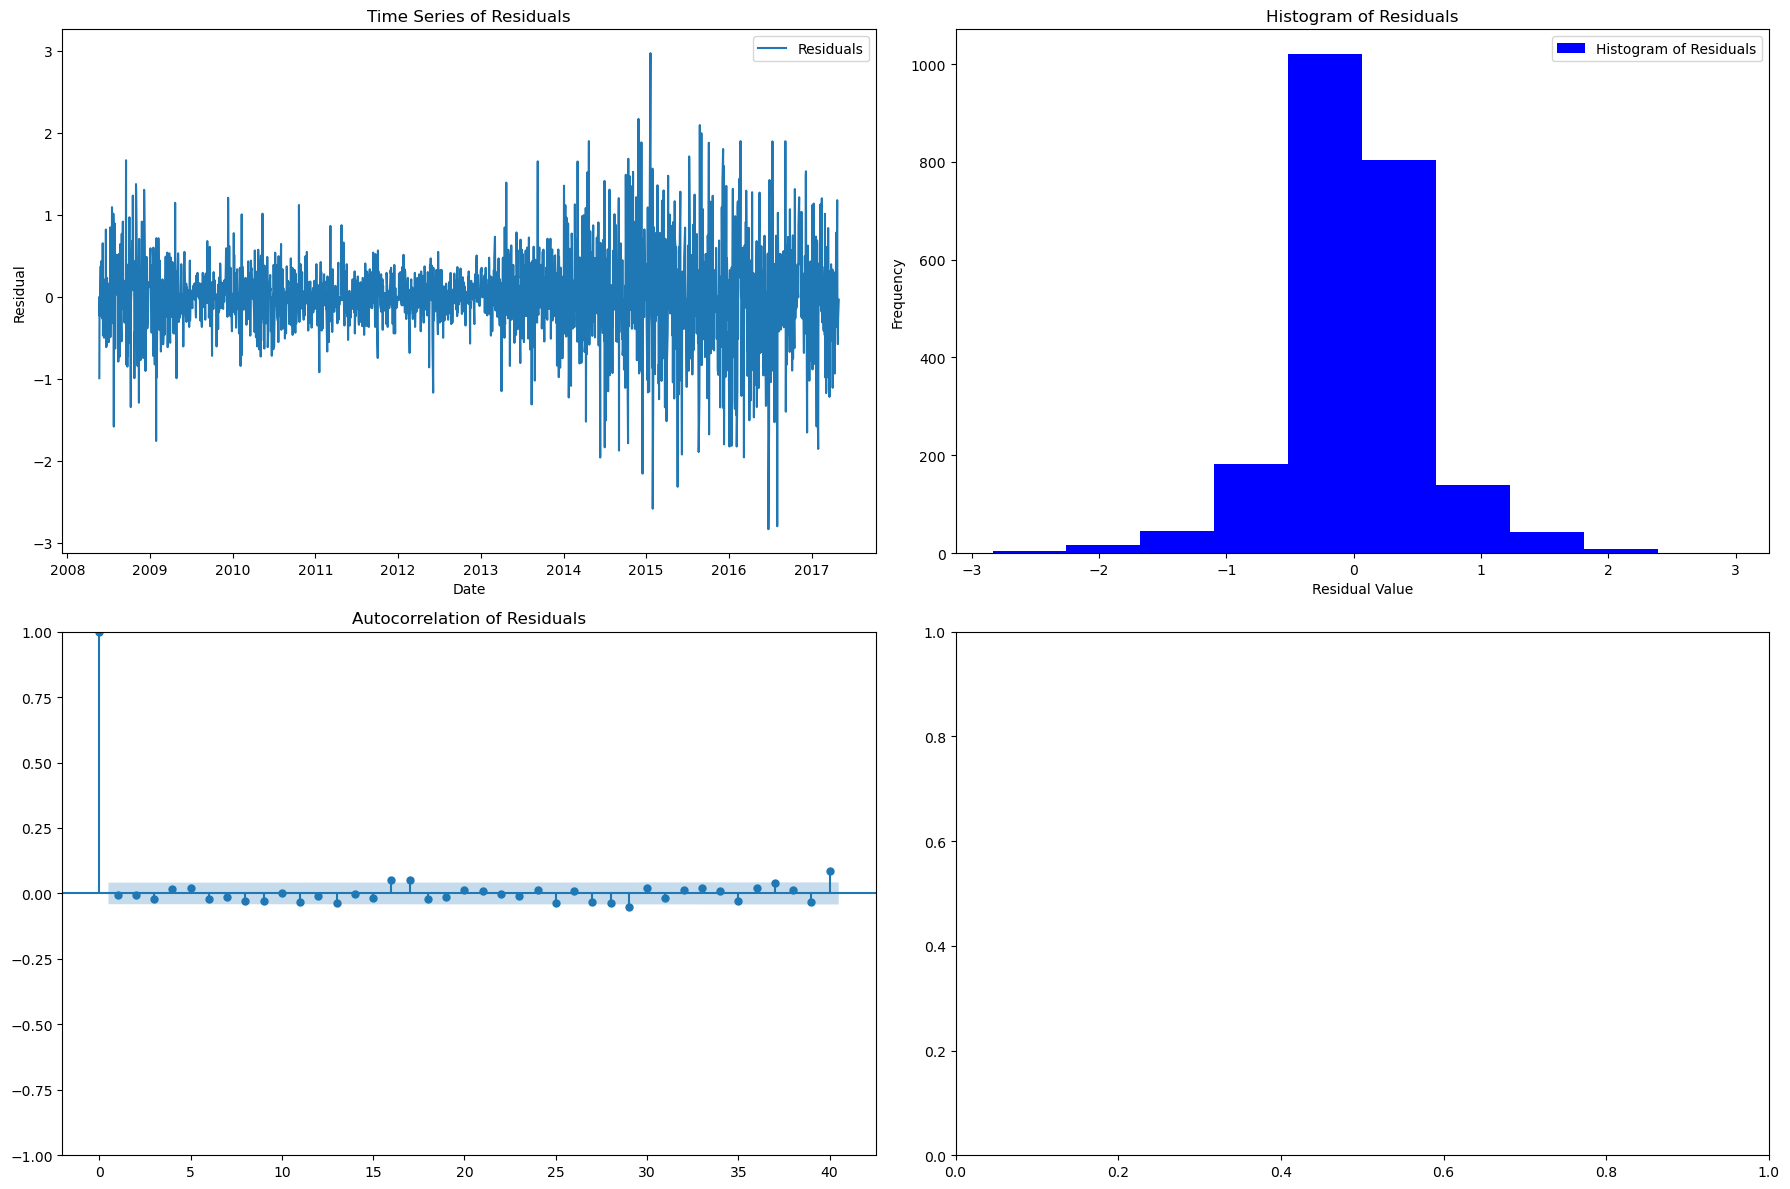

In [35]:
analyze_residuals(model_fit.resid[252:])

In [36]:
predictions_arima = model_fit.forecast(steps = len(val_dal))
arima_error_metrics = evaluate_forecast(val_dal['adj_close'], predictions_arima)

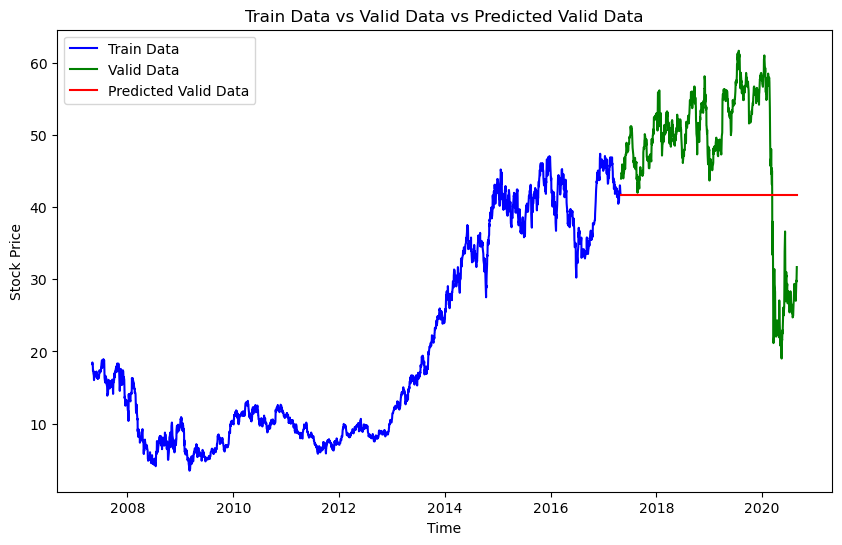

In [37]:
plot_line_graph(train_dal['adj_close'], val_dal['adj_close'], predictions_arima)

In [38]:
arima_error_metrics['methods'] = 'arima'
arima_error_metrics.set_index('methods', inplace=True)

In [39]:
arima_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
arima,10.604609,133.656219,0.246013,0.242591


## 4.SARIMA

In [40]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=train_dal,order=(1,1,1), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model.summary())

Optimization terminated successfully.
         Current function value: 1.093320
         Iterations: 23
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           adj_close   No. Observations:                 2517
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 64)   Log Likelihood               -4450.643
Date:                             Fri, 24 May 2024   AIC                           8907.285
Time:                                     09:59:20   BIC                           8924.699
Sample:                                          0   HQIC                          8913.614
                                            - 2517                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3754      0.012     31.075      0.000       0.352       0.399
ma.L1          0.3890      0.007     55.728      0.000       0.375       0.403
sigma2         0.3053      0.003     91.684      0.000       0.299       0.312
===================================================================================
Ljung-Box (L1) (Q):                 867.93   Jarque-Bera (JB):               386.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,988.979201,4.424178e-206,987.518964,9.127619e-206


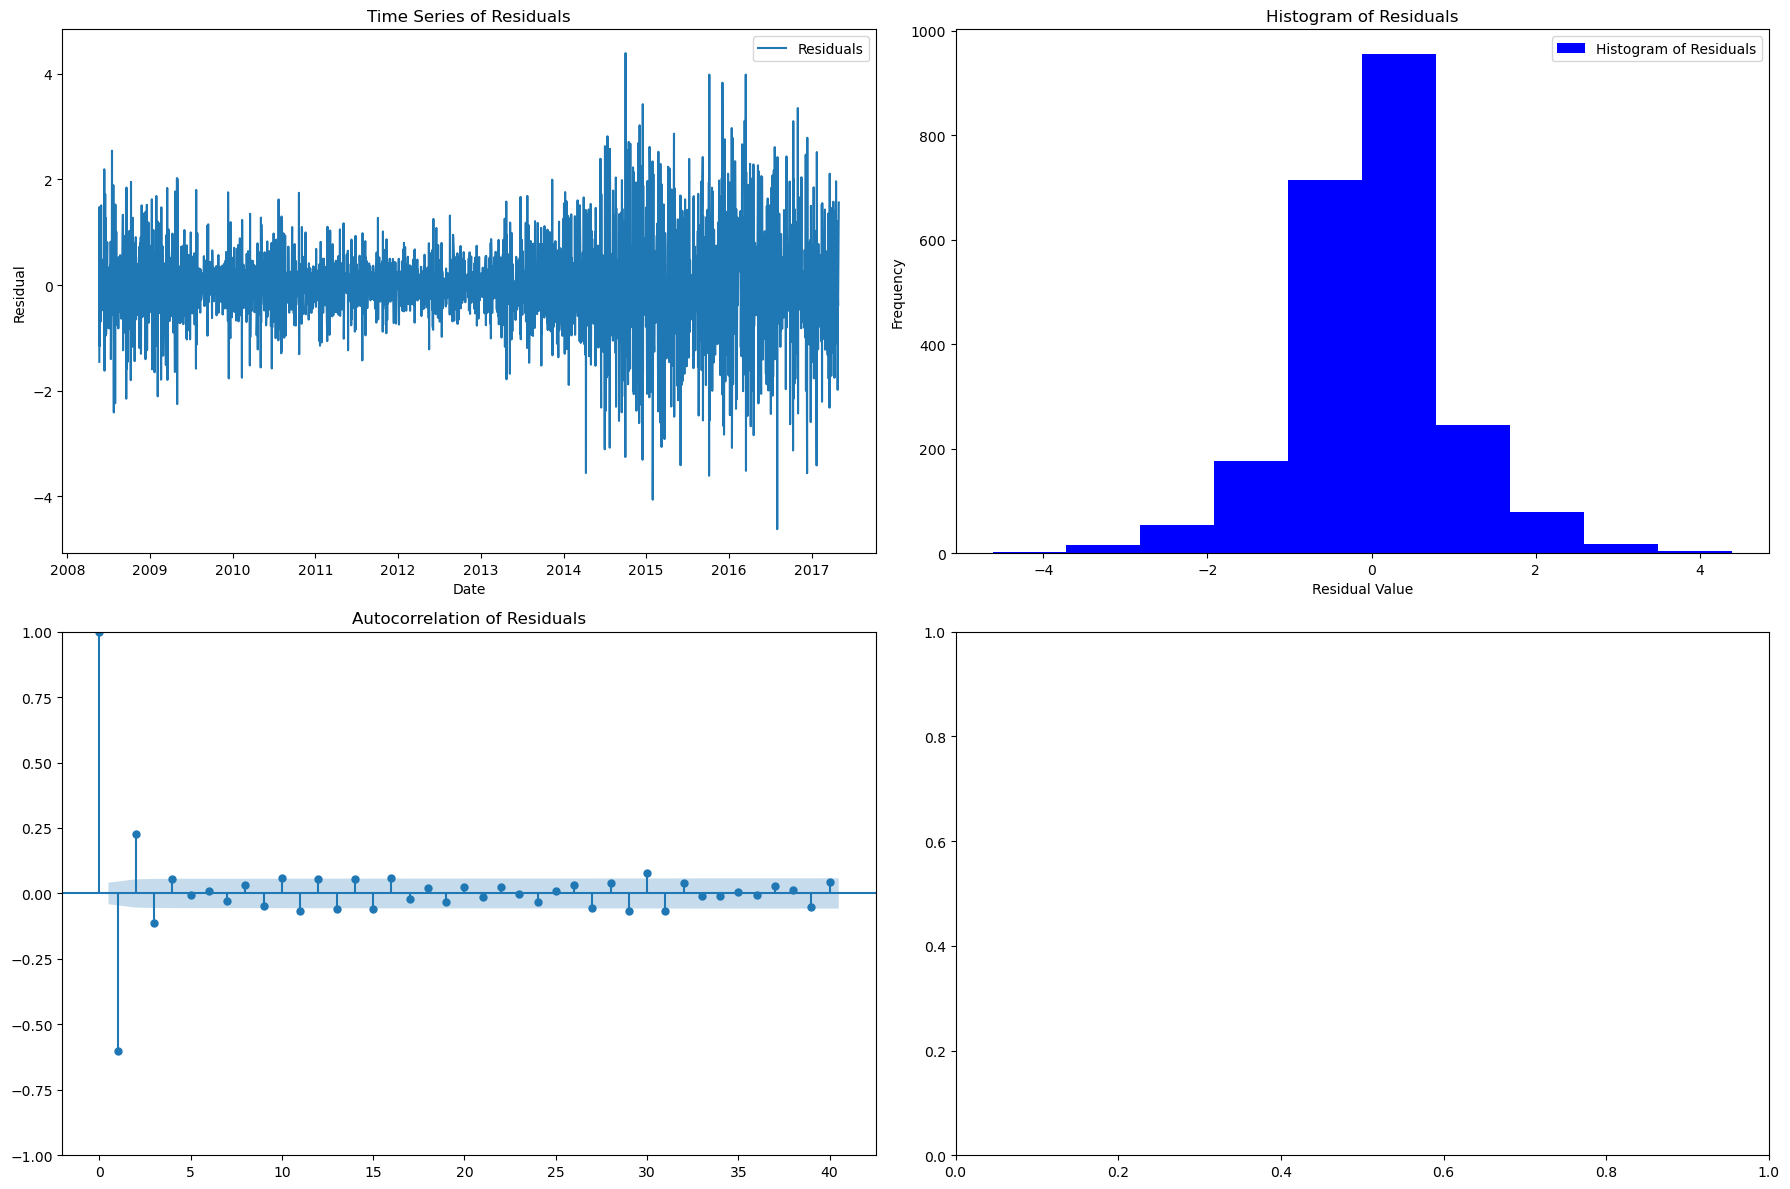

In [41]:
resid = sarima_model.resid
analyze_residuals(resid[252:])

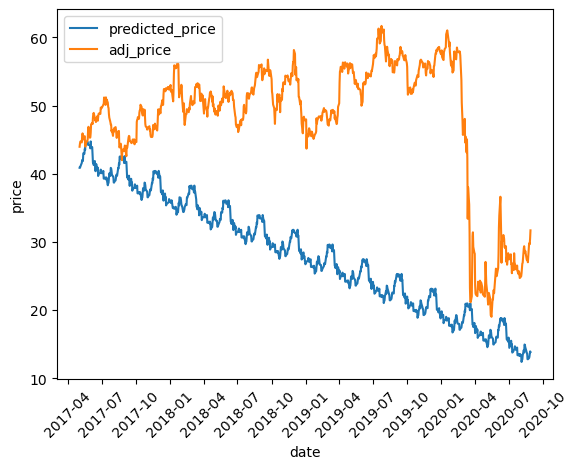

In [42]:
val_pred=sarima_model.forecast(steps = len(val_dal)).to_frame()
val_pred.index = val_dal.index
plt.plot(val_pred['predicted_mean'], label='predicted_price')
plt.plot(val_dal['adj_close'], label='adj_price')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [43]:
predictions_sarima = sarima_model.forecast(steps = len(val_dal))
sarima_error_metrics = evaluate_forecast(val_dal['adj_close'], predictions_sarima)

In [44]:
sarima_error_metrics['methods'] = 'sarima'
sarima_error_metrics.set_index('methods', inplace=True)
sarima_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
sarima,19.734925,500.776363,0.398739,0.526162


## 5.Auto-ARIMA

In [45]:
autoarima_model = pm.auto_arima(train_dal, d=1, D=1, m=64, seasonal=False, stepwise=True)

In [46]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1979.499
Date:                Fri, 24 May 2024   AIC                           3960.998
Time:                        09:59:24   BIC                           3966.828
Sample:                             0   HQIC                          3963.114
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2824      0.005     56.654      0.000       0.273       0.292
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1024.72
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.150207,0.614168,8.119542,0.617161


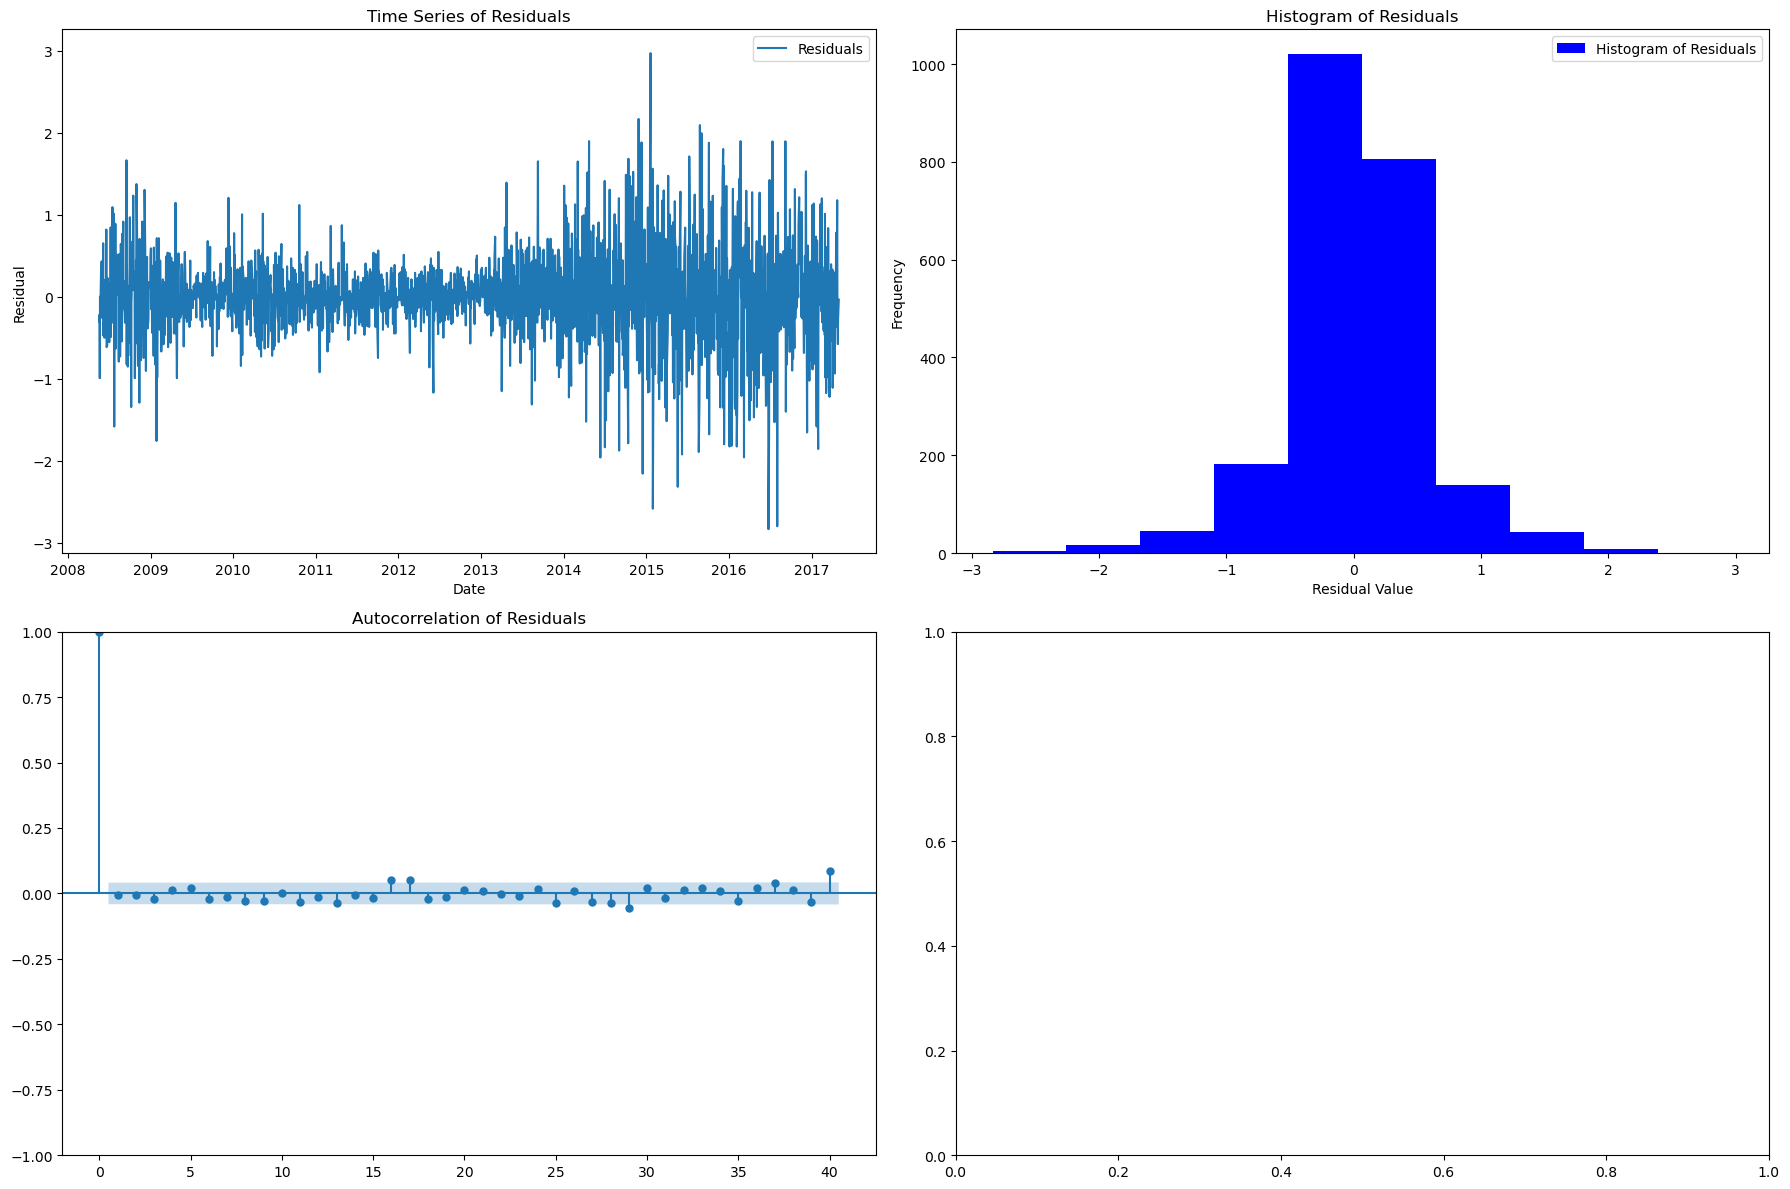

In [47]:
resid = autoarima_model.resid()
analyze_residuals(resid[250:])

In [48]:
predictions_autoarima = autoarima_model.predict(n_periods=len(val_dal))
autoarima_error_metrics = evaluate_forecast(val_dal['adj_close'], predictions_autoarima)

In [49]:
autoarima_error_metrics['methods'] = 'autoarima'
autoarima_error_metrics.set_index('methods', inplace=True)
autoarima_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
autoarima,10.604609,133.656219,0.246013,0.242591


## 5.1 AutoArima(with exog)

In [50]:
SPY = get_ETF_data('SPY', '2000-01-01', '2024-01-01')  
train_spy, val_spy, test_spy = split_time_series(SPY, 0.6,0.2)

In [51]:
exog_train = train_spy.values.reshape(-1, 1)
exog_val = val_spy.values.reshape(-1, 1)

auto_model_exog = pm.auto_arima(train_dal, exog=exog_train,
                           seasonal=True, m=12, trace=False,
                           error_action='ignore', suppress_warnings=True,
                           stepwise=True)

print(auto_model_exog.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1979.499
Date:                Fri, 24 May 2024   AIC                           3960.998
Time:                        09:59:35   BIC                           3966.828
Sample:                             0   HQIC                          3963.114
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2824      0.005     56.654      0.000       0.273       0.292
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1024.72
Prob(Q):                              0.78   Pr

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.141111,0.615056,8.110402,0.618054


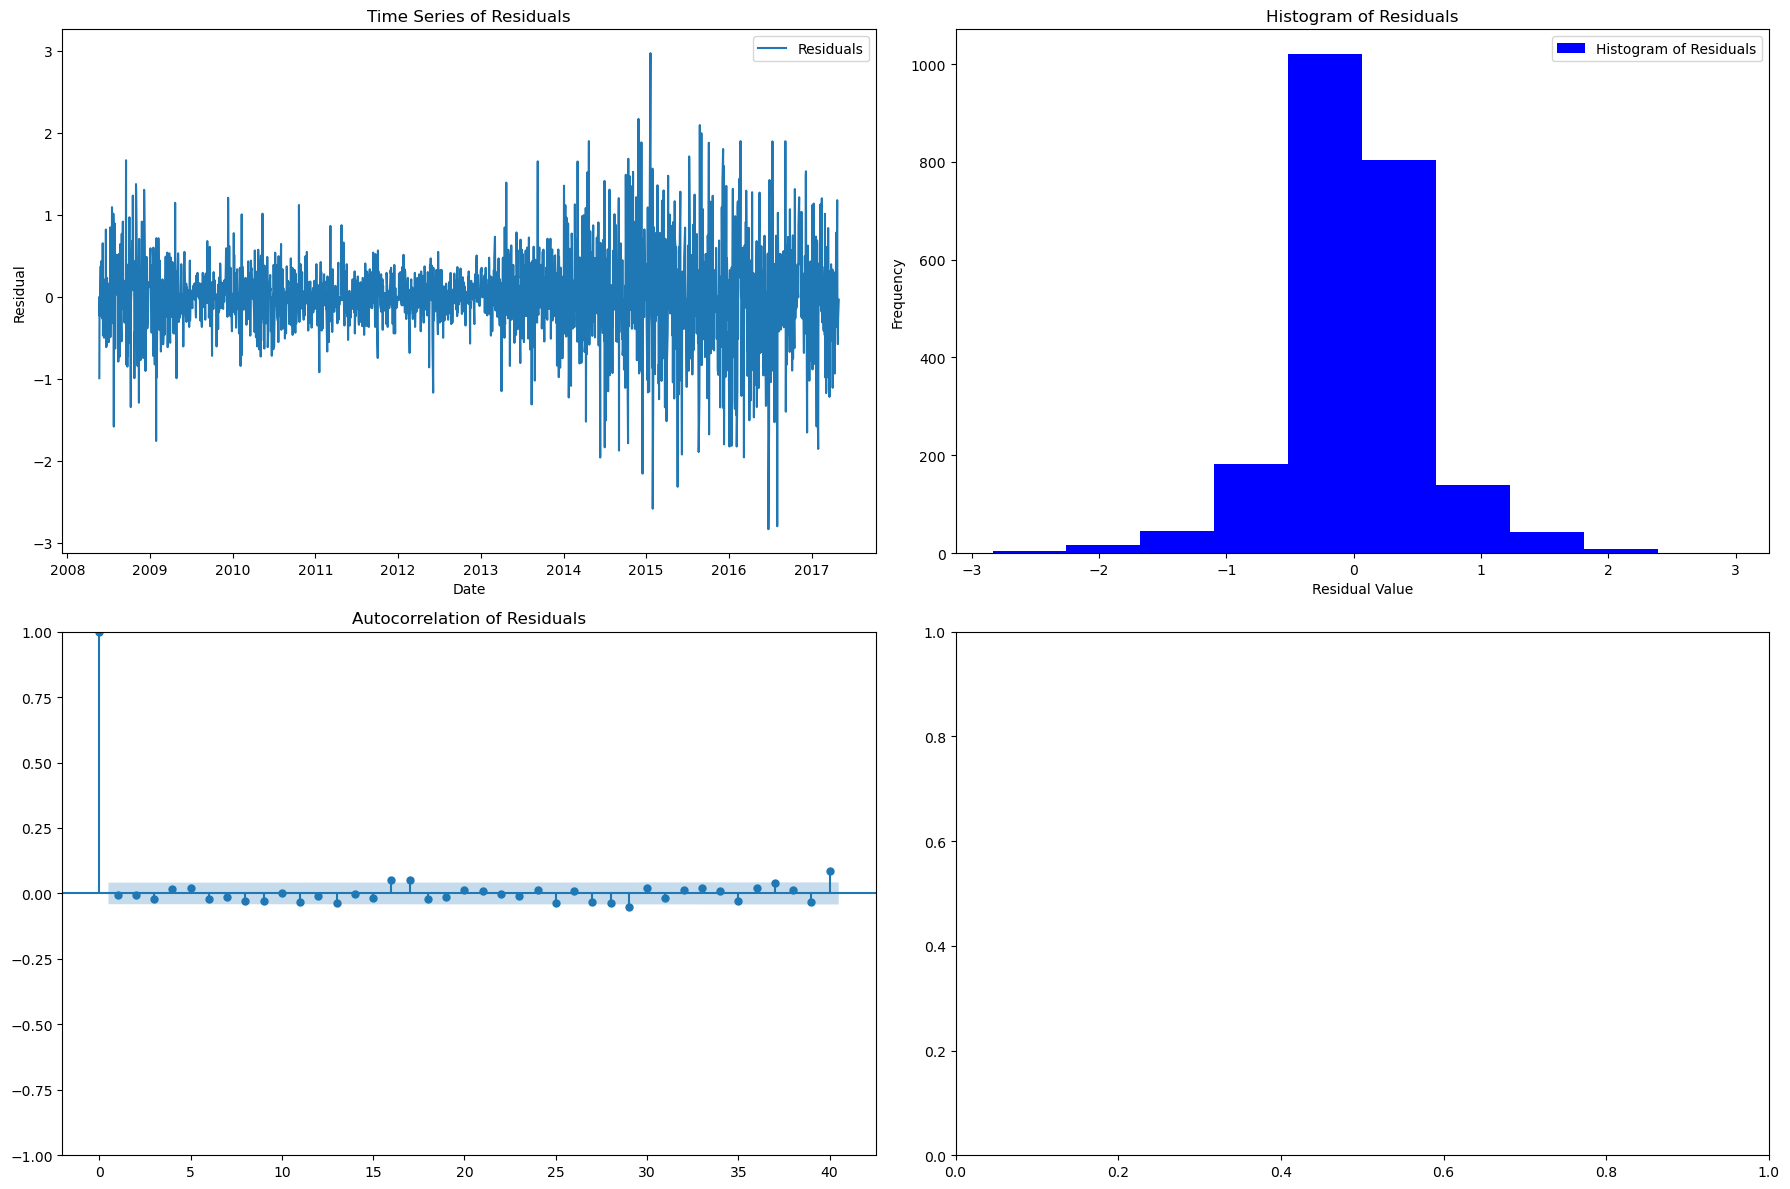

In [52]:
analyze_residuals(auto_model_exog.resid()[252:])

In [53]:
predictions_exog = auto_model_exog.predict(n_periods=len(val_dal), exog=exog_val)

In [54]:
auto_arima_exog_error_metrics = evaluate_forecast(val_dal['adj_close'], predictions_exog)
auto_arima_exog_error_metrics['methods'] = 'auto_arima_exog'
auto_arima_exog_error_metrics.set_index('methods', inplace=True)
auto_arima_exog_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
auto_arima_exog,10.604609,133.656219,0.246013,0.242591


## 6.Prophet

In [113]:
train = train_dal.copy() 
valid = val_dal.copy()

In [114]:
train.rename(columns= {'adj_close': 'y'}, inplace = True)
train.index.name = 'ds'
train['ds'] = train.index
train = train.reset_index(drop=True)
valid.rename(columns= {'adj_close': 'y'}, inplace = True)
valid.index.name = 'ds'
valid['ds'] = valid.index
valid = valid.reset_index(drop=True)

In [115]:
y_train_p = train_dal.copy()
y_train_p['y'] = y_train_p['adj_close']
y_train_p['ds'] = train_dal.index

In [116]:
model_1 = Prophet()
model_1.fit(y_train_p)

10:29:40 - cmdstanpy - INFO - Chain [1] start processing
10:29:40 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
def calc_AIC(model,y_train_new):
    future = model.make_future_dataframe(periods=0)  # forecast only on the training data
    forecast = model.predict(future)

    # Calculate the residuals
    residuals = y_train_new['y'].values - forecast['yhat'].values
    
    # Calculate the log-likelihood
    n = len(y_train_new)
    sigma2 = np.var(residuals)
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(sigma2) + 1)
    
    # Number of parameters (k)
    # Here, k is the number of parameters estimated by the model, including seasonality components.
    # For a basic model, you can approximate it as:
    k = 2 + 2 * model.seasonalities['yearly']['fourier_order']
    
    # Calculate AIC
    AIC = 2 * k - 2 * log_likelihood
    return AIC

In [118]:
model1 = Prophet()
model1.fit(y_train_p)
aic = calc_AIC(model1,y_train_p)
aic

10:29:42 - cmdstanpy - INFO - Chain [1] start processing
10:29:42 - cmdstanpy - INFO - Chain [1] done processing


10709.206068680702

In [119]:
model2 = Prophet()
model2.add_seasonality(name='quarterly', period =90, fourier_order=7, prior_scale=0.5)
model2.fit(y_train_p)
aic = calc_AIC(model2,y_train_p)
aic

10:29:44 - cmdstanpy - INFO - Chain [1] start processing
10:29:44 - cmdstanpy - INFO - Chain [1] done processing


10680.25229262896

In [120]:
model2 = Prophet()
model2.add_seasonality(name='weekly', period =7, fourier_order=3, prior_scale=0.5)
model2.fit(y_train_p)
aic = calc_AIC(model2,y_train_p)
aic

10:29:45 - cmdstanpy - INFO - Chain [1] start processing
10:29:46 - cmdstanpy - INFO - Chain [1] done processing


10709.466202893173

In [121]:
model3 = Prophet()
model3.add_seasonality(name='yearly', period =360, fourier_order=10, prior_scale=0.5)
model3.fit(y_train_p)
aic = calc_AIC(model3,y_train_p)
aic

10:29:48 - cmdstanpy - INFO - Chain [1] start processing
10:29:48 - cmdstanpy - INFO - Chain [1] done processing


10554.258939703337

In [122]:
result = []
for i in [0.001,0.05,0.1,1]:
    model4 = Prophet(yearly_seasonality=True, changepoint_prior_scale=i)
    model4.fit(y_train_p)
    
    aic = calc_AIC(model4,y_train_p)
    print(aic)

10:29:49 - cmdstanpy - INFO - Chain [1] start processing
10:29:50 - cmdstanpy - INFO - Chain [1] done processing
10:29:50 - cmdstanpy - INFO - Chain [1] start processing


16701.478744553653


10:29:51 - cmdstanpy - INFO - Chain [1] done processing
10:29:51 - cmdstanpy - INFO - Chain [1] start processing


10709.206068680702


10:29:52 - cmdstanpy - INFO - Chain [1] done processing
10:29:52 - cmdstanpy - INFO - Chain [1] start processing


10577.075453320176


10:29:53 - cmdstanpy - INFO - Chain [1] done processing


9502.511420919695


In [123]:
model_1 = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model_1.fit(y_train_p)

10:29:54 - cmdstanpy - INFO - Chain [1] start processing
10:29:55 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
if isinstance(val_dal.index, pd.DatetimeIndex):
    validation_dates = pd.DataFrame({'ds': val_dal.index})
else:

    validation_dates = pd.DataFrame({'ds': pd.to_datetime(val_dal['ds'])})


all_dates = pd.concat([
    model_1.history[['ds']],  
    validation_dates 
]).drop_duplicates().reset_index(drop=True)

future = pd.DataFrame({'ds': all_dates['ds']})

In [125]:
forecast = model_1.predict(future)

training_actuals = model_1.history[['ds', 'y']]
results = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], training_actuals, on='ds', how='right')

results['residuals'] = results['y'] - results['yhat'] #training residual

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,13520.796507,0.0,13486.171929,0.0


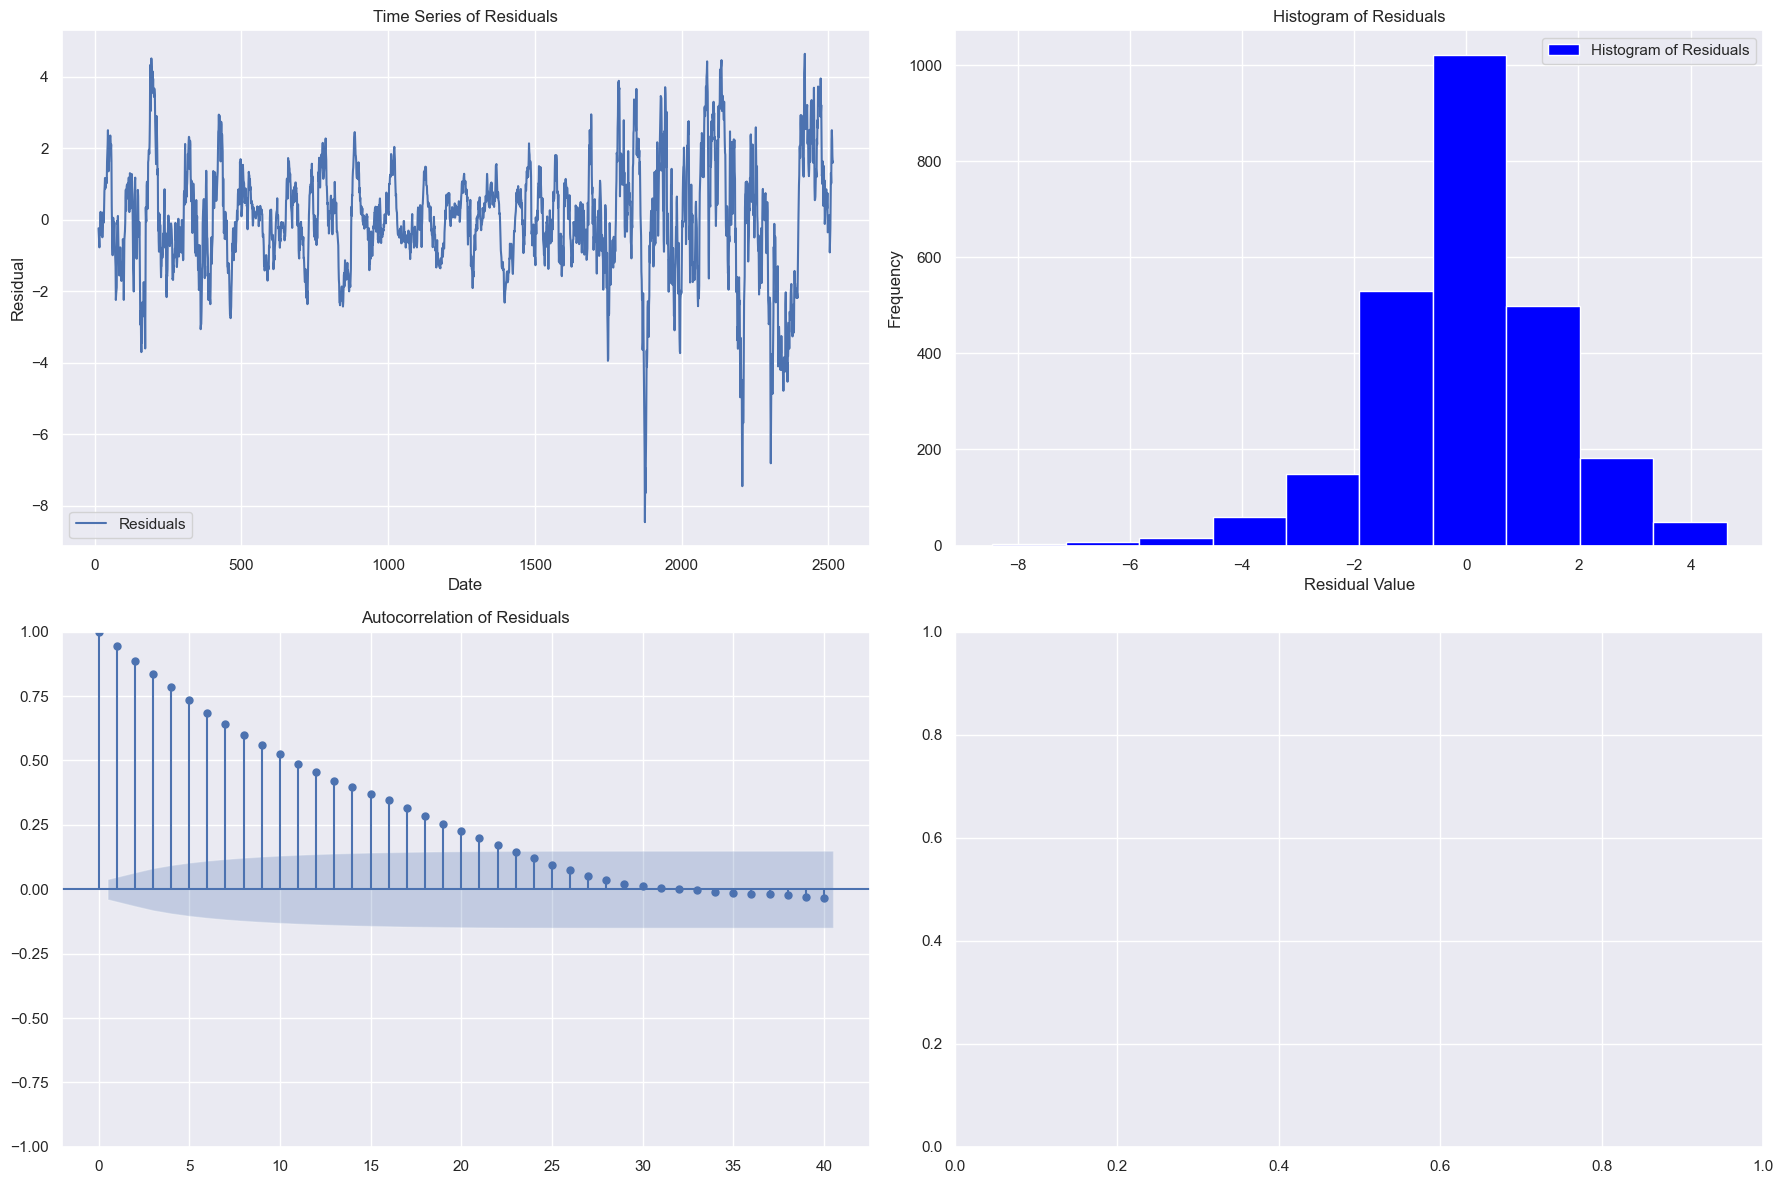

In [126]:
analyze_residuals(results['residuals'])

In [127]:
mae_prophet1 = mean_absolute_error(val_dal['adj_close'],forecast['yhat'][-len(val_dal):])
mse_prophet1 = mean_squared_error(val_dal['adj_close'],forecast['yhat'][-len(val_dal):])
mape_prophet1 = mean_absolute_percentage_error(val_dal['adj_close'],forecast['yhat'][-len(val_dal):])
smape_prophet1 = mean_absolute_percentage_error(val_dal['adj_close'],forecast['yhat'][-len(val_dal):], symmetric = True)

In [128]:
prophet_error_metrics = pd.DataFrame({'MAE': [mae_prophet1], 'MSE': [mse_prophet1], 'MAPE': [mape_prophet1], 'sMAPE': [smape_prophet1]})
prophet_error_metrics['methods'] = 'prophet'
prophet_error_metrics.set_index('methods', inplace=True)
prophet_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
prophet,12.541388,185.647222,0.262538,0.290856


## 7.1 VARMA(with SPY)

In [71]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, q_stat

In [72]:
SPY = get_ETF_data('SPY', '2000-01-01', '2024-01-01')   

In [73]:
varma_dal = DAL.merge(SPY, left_index=True, right_index=True, how='left').dropna()

In [74]:
varma_dal.rename(columns={'adj_close_x': 'DAL', 'adj_close_y': 'SPY'}, inplace=True)

In [75]:
check_num_stationarity(varma_dal['DAL'])
check_num_stationarity(varma_dal['SPY'])

The time series data is stationary.
Number of differencing needed is: 1
The time series data is stationary.
Number of differencing needed is: 1


In [76]:
df_diff = varma_dal.diff().dropna()

In [77]:
alpha = 0.05

In [78]:
granger_results_a = grangercausalitytests(df_diff, maxlag=6, verbose=False)

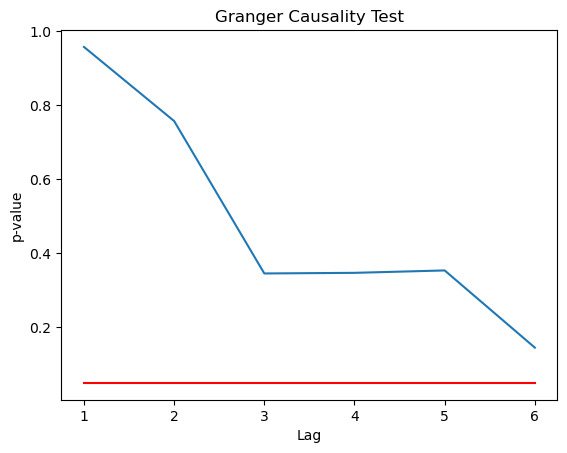

In [79]:
res_list = []
for lag, v in granger_results_a.items():
    res = {}
    res['Lag'] = lag
    for test, stats in v[0].items():
        res[test] = stats[1]

    res_list.append(res)

pvals = pd.DataFrame(res_list)
pvals.set_index('Lag', inplace=True)
pvals_graph = pvals['params_ftest']

pvals_graph.plot(title='Granger Causality Test')
alpha_ser = pd.Series([alpha]*len(pvals_graph), index=pvals_graph.index)
alpha_ser.plot(color='red')
plt.ylabel('p-value')
plt.show()

In [80]:
train_varma, val_varma, test_varma = split_time_series(df_diff, 0.6,0.2)

In [81]:
from statsmodels.tsa.vector_ar.var_model import VAR

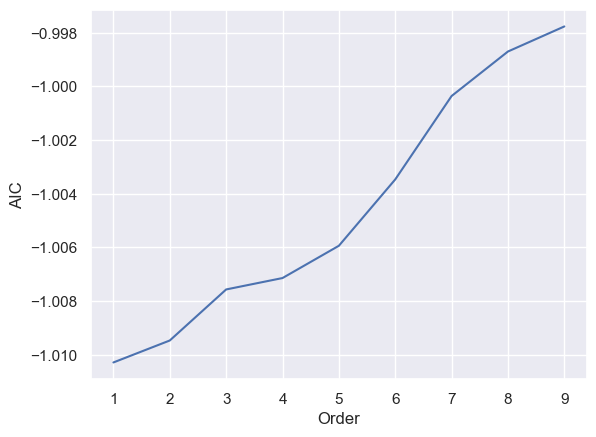

In [82]:
var_model=VAR(train_varma)

results_aic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_aic.append(results.aic)
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

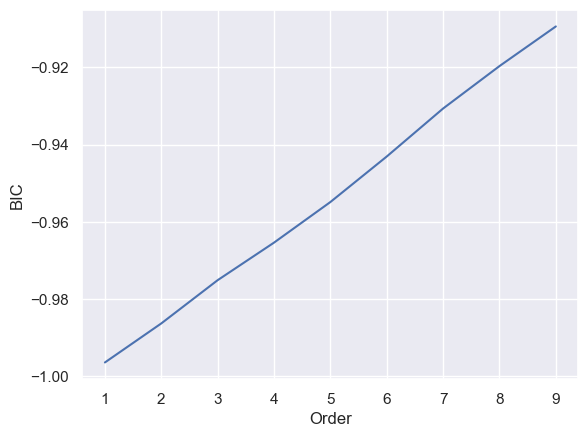

In [83]:
results_bic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,10,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

In [84]:
results_var = var_model.fit(1)
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, May, 2024
Time:                     09:59:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.996381
Nobs:                     2515.00    HQIC:                  -1.00524
Log likelihood:          -5860.82    FPE:                   0.364113
AIC:                     -1.01029    Det(Omega_mle):        0.363246
--------------------------------------------------------------------
Results for equation DAL
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.008957         0.010607            0.844           0.398
L1.DAL        -0.003796         0.022708           -0.167           0.867
L1.SPY         0.008065         0.009331            0.864           0.387

Results for equ

In [85]:
yhat = results.forecast(var_model.endog, steps=len(val_varma))
idx= val_varma.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns = val_varma.columns

In [86]:
df_preds

,DAL,SPY
date,,
2017-05-02,-0.043826,0.042391
2017-05-03,-0.044782,-0.048664
2017-05-04,-0.031275,0.084909
2017-05-05,-0.010596,0.046743
2017-05-08,-0.003707,-0.023076
...,...,...
2020-08-21,0.010128,0.040561
2020-08-24,0.010128,0.040561
2020-08-25,0.010128,0.040561


In [87]:
last_train_value = train_varma.iloc[-1]
df_preds_original_scale = df_preds.copy()
for column in df_preds.columns:
    df_preds_original_scale[column] = df_preds[column].cumsum() + last_train_value[column]


In [88]:
var_error_metrics = evaluate_forecast(val_varma['DAL'], df_preds_original_scale['DAL'])
var_error_metrics['methods'] = 'var'
var_error_metrics.set_index('methods', inplace=True)
var_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
var,4.127421,24.014247,1.931429e+06,1.687118


## 8. TBATS

In [89]:
train_dal.index = pd.date_range(start=train_dal.index[0], periods=len(train_dal), freq='B')
val_dal.index = pd.date_range(start=val_dal.index[0], periods=len(val_dal), freq='B')

In [90]:
bats_forecaster = BATS(
    use_box_cox=True,
    box_cox_bounds=(0, 1),
    use_trend=True,
    use_damped_trend=None,
    sp=12,
    use_arma_errors=True,
    show_warnings=True,
    n_jobs=None,
    multiprocessing_start_method='spawn',
    context=None,

)

bats_forecaster.fit(train_dal)

BATS(sp=12, use_box_cox=True, use_trend=True)

In [91]:
fh_list = list(range(1,len(val_dal)+1))

In [92]:
ypred_bats = bats_forecaster.predict(fh= fh_list)

In [93]:
TABTS_error_metrics = evaluate_forecast(val_dal['adj_close'],ypred_bats['adj_close'])

In [94]:
TABTS_error_metrics['methods'] = 'TBATS'
TABTS_error_metrics.set_index('methods', inplace=True)
TABTS_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
TBATS,10.624843,133.993855,0.246324,0.243076


## 9.GARCH

In [95]:
def fit_garch_model(train_data, p, q):
    model = arch_model(train_data, vol='Garch', p=p, q=q)
    model_fit = model.fit(disp='off')
    return model_fit.aic, model_fit

In [96]:
best_aic = float('inf')
best_model = None
best_pq = None

for p in range(1, 6):
    for q in range(1, 6):
        aic, model_fit = fit_garch_model(train_dal['adj_close'], p, q)
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_pq = (p, q)
best_pq

(1, 5)

In [97]:
forecast = best_model.forecast(horizon=len(val_dal))
forecast = pd.Series(forecast.variance.values[-1,:], index=val_dal.index)

In [98]:
garch_error_metrics = evaluate_forecast(val_dal['adj_close'], forecast)   

In [99]:
garch_error_metrics['methods'] = 'garch'
garch_error_metrics.set_index('methods', inplace=True)
garch_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
garch,1066.226829,1.136973e+06,23.811862,1.835155


## 10.Model Selection 

In [130]:
result_error_metrics = pd.concat([smoothing_error_metrics, arima_error_metrics, sarima_error_metrics, autoarima_error_metrics, auto_arima_exog_error_metrics, prophet_error_metrics, var_error_metrics, TABTS_error_metrics, garch_error_metrics])

In [131]:
result_error_metrics

,MAE,MSE,MAPE,sMAPE
methods,,,,
smoothing,9.558385,223.75038,0.286727,0.199246
arima,10.604609,133.656219,0.246013,0.242591
sarima,19.734925,500.776363,0.398739,0.526162
autoarima,10.604609,133.656219,0.246013,0.242591
auto_arima_exog,10.604609,133.656219,0.246013,0.242591
prophet,12.541388,185.647222,0.262538,0.290856
var,4.127421,24.014247,1931429.282336,1.687118
TBATS,10.624843,133.993855,0.246324,0.243076
garch,1066.226829,1136972.529747,23.811862,1.835155


## 11. Result display 

In [105]:
best_method = 'mul'
best_period = 64

model = ExponentialSmoothing(
    train_dal,
    trend=best_method,
    seasonal='mul',
    seasonal_periods=best_period
).fit()

forecast_length = len(test_dal)
y_pred = model.forecast(forecast_length)
y_pred.index = test_dal.index

In [106]:
evaluate_forecast(test_dal['adj_close'], y_pred)

,MAE,MSE,MAPE,sMAPE
0,12.329091,202.596207,0.348588,0.28124


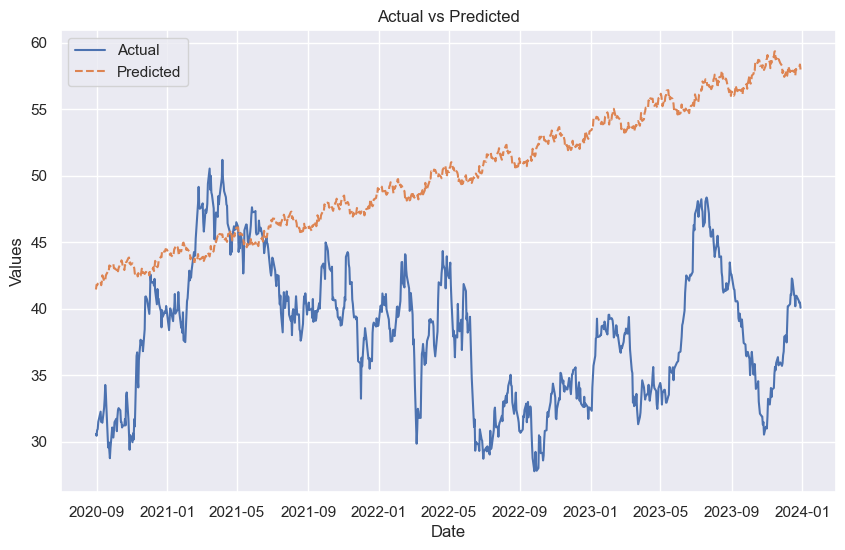

In [107]:
comparison_df = pd.concat([test_dal, y_pred], axis=1, keys=['Actual', 'Predicted'])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_dal.index, test_dal, label='Actual')
plt.plot(y_pred.index, y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

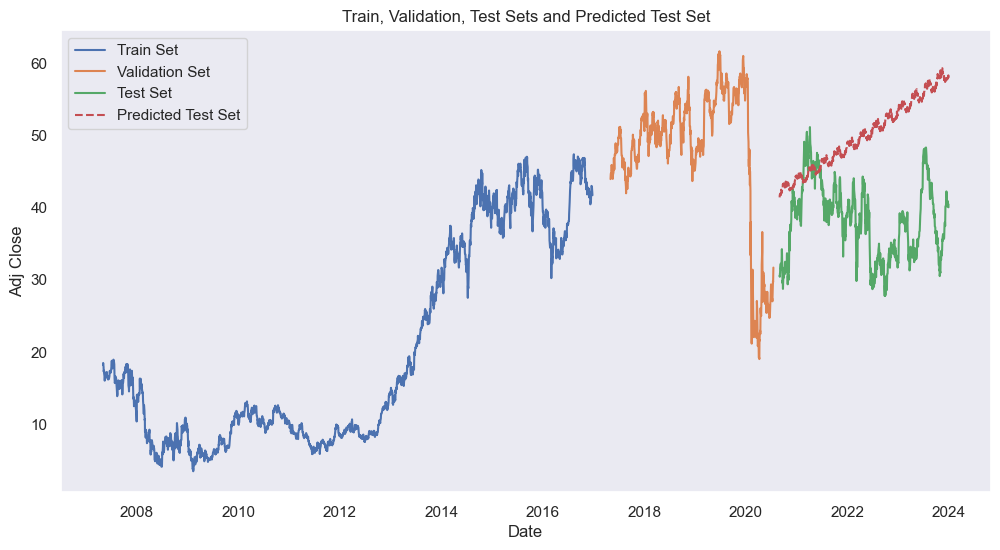

In [111]:
plt.figure(figsize=(12, 6))
#plt.gca().set_facecolor('white')
plt.plot(train_dal.index, train_dal['adj_close'], label='Train Set')
plt.plot(val_dal.index, val_dal['adj_close'], label='Validation Set')
plt.plot(test_dal.index, test_dal['adj_close'], label='Test Set')
plt.plot(y_pred.index, y_pred, label='Predicted Test Set', linestyle='--')

plt.title('Train, Validation, Test Sets and Predicted Test Set')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(False)

plt.show()